In [1]:
import numpy as np
import torch 
import torch.nn as nn
import math 
import h5py
import yaml
import pickle
import sys
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


import src.models as models
import src.dataset as ds
import src.train_pcdae as train_pcdae
import src.inference_pcdae as inference
import src.data_preparation as data_prep
import src.inference_regressor as constraints


In [2]:

#### inference study

def get_pcdae_model_dataset(seed, device, config):
    
    data_dict = data_prep.prepare_data_model(seed, "../" + config['data']["data_path"], config['training']["ratio_test_val_train"])

    X_test_scaled, y_test_scaled = data_dict['test']
    scaler_X, scaler_Y = data_dict['scalers']

    batch_size = X_test_scaled.shape[0]

    test_dataset = ds.LTPDataset(X_test_scaled, y_test_scaled)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    ###* define the PCDAE architecture
    x_dim = config['model']['x_dim']
    y_dim = config['model']['y_dim']
    hidden_dim = config['model']['hidden_dim']
        
    s_noise = float(config['model']['s_noise'])
    sigma_max = float(config['model']['sigma_max'])
    noise_dist = config['training']['noise_dist']
        
    pcdae = models.PCDAE(x_dim=x_dim, y_dim=y_dim, hidden_dim=hidden_dim).to(device)
    pcdae.load_state_dict(torch.load(f"../models_pcdae_saved/pcdae_inference_{seed}.pth"))
    
    return {
        'scalers': (scaler_X, scaler_Y),
        'data': (test_dataset, test_dataloader),
        'pcdae': pcdae,
        'sigmas': (s_noise, sigma_max),
        'noise_dist': noise_dist
    }


def get_ebm_pcade_model_dataset(seed, device, config):
    
    data_dict = data_prep.prepare_data_model(seed, "../" + config['data']["data_path"], config['training']["ratio_test_val_train"])

    X_test_scaled, y_test_scaled = data_dict['test']
    scaler_X, scaler_Y = data_dict['scalers']

    batch_size = X_test_scaled.shape[0]

    test_dataset = ds.LTPDataset(X_test_scaled, y_test_scaled)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    ###* define the PCDAE architecture
    x_dim = config['model']['x_dim']
    y_dim = config['model']['y_dim']
    hidden_dim = config['model']['hidden_dim']
        
    s_noise = float(config['model']['s_noise'])
    sigma_max = float(config['model']['sigma_max'])
    noise_dist = config['training']['noise_dist']
        
    ebm_pcdae = models.PCDAE_EBM(x_dim=x_dim, y_dim=y_dim, hidden_dim=hidden_dim).to(device)
    ebm_pcdae.load_state_dict(torch.load(f"../models_ebm_pcdae_saved/ebm_pcdae_cosine_inference_{seed}.pth"))
    
    return {
        'scalers': (scaler_X, scaler_Y),
        'data': (test_dataset, test_dataloader),
        'ebm_pcdae': ebm_pcdae,
        'sigmas': (s_noise, sigma_max),
        'noise_dist': noise_dist
    }


def get_regressor_model_dataset(seed, device, config):
    
    data_dict = data_prep.prepare_data_model(seed, "../" + config['data']["data_path"], config['training']["ratio_test_val_train"])

    X_test_scaled, y_test_scaled = data_dict['test']
    scaler_X, scaler_Y = data_dict['scalers']

    batch_size = X_test_scaled.shape[0]

    test_dataset = ds.LTPDataset(X_test_scaled, y_test_scaled)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    ###* define the regressor architecture
    x_dim = config['model']['x_dim']
    y_dim = config['model']['y_dim']
    hidden_sizes = config['model']['hidden_size']
    
    regressor = models.Regressor(input_size=x_dim, output_size=y_dim, hidden_sizes=hidden_sizes).to(device)
    
    regressor.load_state_dict(torch.load(f"../models_regressor_saved/regressor_inference_{seed}.pth"))
    
    solver = constraints.ProjectionSolver(scaler_X, scaler_Y, x_dim=x_dim, p_dim=y_dim)
    
    return {
        'scalers': (scaler_X, scaler_Y),
        'data': (test_dataset, test_dataloader, X_test_scaled),
        'regressor': regressor,
        'solver': solver
    }


In [3]:
# config_file = "../config_regressor.yaml"
# seed_vec = np.arange(1, 400, 40, dtype=int)
# device = torch.device('cpu')


# try:
#     with open(config_file, 'r') as file:
#         config = yaml.safe_load(file)
# except FileNotFoundError:
#     print("Error: The file 'config.yaml' was not found.")
#     exit()
# except yaml.YAMLError as e:
#     print(f"Error parsing YAML file: {e}")
#     exit()


# regressor_vec = []
# for seed in seed_vec:
#     dict_aux = get_regressor_model_dataset(seed, device, config)
#     regressor_vec.append(dict_aux)

In [4]:


def constraint_regressor_study():

    y_vec = []
    p_vec = []
    
    hy_vec = []
    hp_vec = []

    for idx in range(len(regressor_vec)):
            
        torch.manual_seed(seed_vec[idx])
        np.random.seed(seed_vec[idx])
            
        test_dataset, _, input_dataset = regressor_vec[idx]['data']
        scaler_X, scaler_Y = regressor_vec[idx]['scalers']
        regressor = regressor_vec[idx]['regressor']
        solver = regressor_vec[idx]['solver']
        
        y_pred, p_pred = solver.solve_batch(regressor, input_dataset, scaler_Y)
        
        
        h_y = inference.get_constraints_scalar(torch.from_numpy(input_dataset), torch.from_numpy(y_pred), scaler_X, scaler_Y).abs().mean()
        h_p = inference.get_constraints_scalar(torch.from_numpy(input_dataset), torch.from_numpy(p_pred), scaler_X, scaler_Y).abs().mean()
        
        y_vec.append(y_pred)
        p_vec.append(p_vec)
        hy_vec.append(h_y.detach().numpy())
        hp_vec.append(h_p.detach().numpy())
        
    return y_vec, p_vec, np.array(hy_vec), np.array(hp_vec)

In [5]:

config_file = "../config_pcdae.yaml"
seed_vec = np.arange(1, 400, 40, dtype=int)
device = torch.device('cpu')


try:
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print("Error: The file 'config.yaml' was not found.")
    exit()
except yaml.YAMLError as e:
    print(f"Error parsing YAML file: {e}")
    exit()
    


In [6]:

pcdae_vec = []
for seed in seed_vec:
    dict_aux = get_pcdae_model_dataset(seed, device, config)
    pcdae_vec.append(dict_aux)


ebm_pcdae_vec = []
for seed in seed_vec:
    dict_aux = get_ebm_pcade_model_dataset(seed, device, config)
    ebm_pcdae_vec.append(dict_aux)



In [7]:


def nb_level_pcdae_study(nb_levels_vec, size_level=10):

    test_init_vec = []
    test_refine_vec = []
    
    hy_vec = []
    hp_vec = []
    
    for counter, nb_levels in enumerate(nb_levels_vec):
        
        aux_init = []
        aux_refine = []
        
        for idx in range(len(pcdae_vec)):
            
            torch.manual_seed(seed_vec[idx])
            np.random.seed(seed_vec[idx])
            
            test_dataset, test_dataloader = pcdae_vec[idx]['data']
            scaler_X, scaler_Y = pcdae_vec[idx]['scalers']
            pcdae = pcdae_vec[idx]['pcdae']
            s_noise, sigma_max = pcdae_vec[idx]['sigmas']
            noise_dist = pcdae_vec[idx]['noise_dist']
            
            linear = torch.linspace(1.0, 0.0, nb_levels)
            noise_schedule = (sigma_max * torch.sin((linear + s_noise)/(1.0 + s_noise) * torch.pi / 2.0))
            
            steps_vec = np.linspace(size_level, size_level, nb_levels, dtype=int)

            test_init_loss = 0.0
            test_refine_loss = 0.0

            for i, (x, y) in enumerate(test_dataloader):
                
                y_init = torch.randn_like(y)
                
                y_refined = inference.inference_scheduled_ODE(pcdae, x, y_init, 
                            noise_schedule=noise_schedule, steps_per_level=steps_vec[counter], eps_clip=None)

                loss_init = nn.MSELoss()(y_init, y)
                loss_refined = nn.MSELoss()(y_refined, y)
                
                test_init_loss += loss_init.item()
                test_refine_loss += loss_refined.item()
        
            test_init_loss /= len(test_dataloader)
            test_refine_loss /= len(test_dataloader)
            
            aux_init.append(test_init_loss)
            aux_refine.append(test_refine_loss)
        
        test_init_vec.append(aux_init)
        test_refine_vec.append(aux_refine)
        
        print("counter: ", (counter+1)/len(nb_levels_vec))
        
    return test_init_vec, test_refine_vec

In [8]:

# nb_levels_vec = [50, 150, 300, 450, 600, 750, 900, 1050]

nb_levels_vec = [1, 3, 6, 10, 30, 50, 80, 100, 120, 140]
size_level = 1
test_init_vec, test_refine_vec = nb_level_pcdae_study(nb_levels_vec, size_level=size_level)




counter:  0.1
counter:  0.2
counter:  0.3
counter:  0.4
counter:  0.5
counter:  0.6
counter:  0.7
counter:  0.8
counter:  0.9
counter:  1.0


In [9]:
test_refine_arr = np.array(test_refine_vec)

mean_refine_plot = np.mean(np.sqrt(test_refine_arr), axis=1)
std_refine_plot = np.std(np.sqrt(test_refine_arr), axis=1)



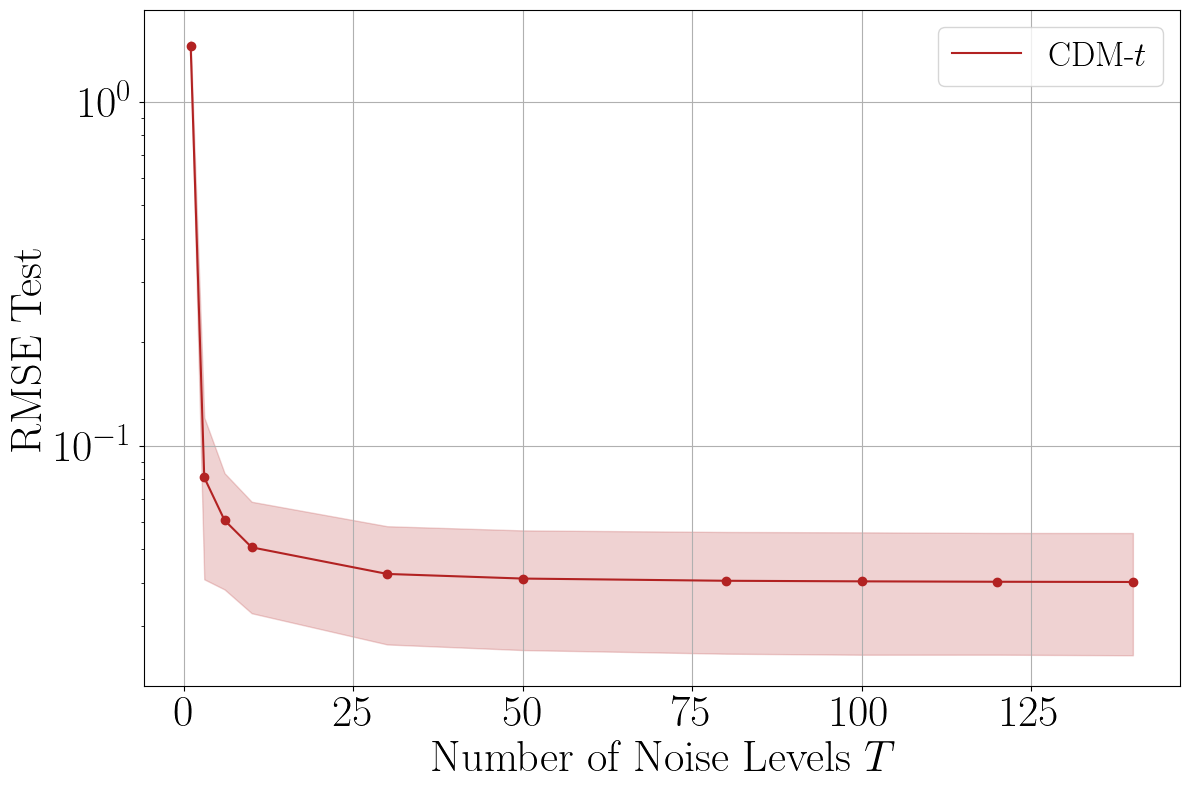

In [23]:


fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

color="firebrick"

plt.plot(nb_levels_vec, mean_refine_plot, color=color, label=r"CDM-$t$")
plt.plot(nb_levels_vec, mean_refine_plot, 'o', color=color)
plt.fill_between(nb_levels_vec,
                    mean_refine_plot - std_refine_plot,
                    mean_refine_plot + std_refine_plot,
                    alpha=0.2, color=color)



plt.xlabel(r'Number of Noise Levels $T$', fontsize=32)
plt.ylabel(r'RMSE Test', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.legend(fontsize=25)
# plt.ylim(0.005, 0.09)
plt.yscale('log')
plt.tight_layout()
plt.grid()
# plt.yscale('log')
# plt.xscale('log')

plt.savefig("scaling_inference_CDM-t_V3.png")

In [11]:
print(mean_refine_plot)

[1.45271445 0.08092953 0.06075902 0.0507038  0.04243231 0.04114063
 0.0405364  0.04038146 0.04027051 0.04021179]


In [12]:

### study K per level 

def K_level_pcdae_study(K_size_vec, nb_levels=15):

    test_init_vec = []
    test_refine_vec = []

    
    for counter, K_size in enumerate(K_size_vec):
        
        aux_init = []
        aux_refine = []
        
        for idx in range(len(pcdae_vec)):
            
            torch.manual_seed(seed_vec[idx])
            np.random.seed(seed_vec[idx])
            
            test_dataset, test_dataloader = pcdae_vec[idx]['data']
            scaler_X, scaler_Y = pcdae_vec[idx]['scalers']
            pcdae = pcdae_vec[idx]['pcdae']
            s_noise, sigma_max = pcdae_vec[idx]['sigmas']
            noise_dist = pcdae_vec[idx]['noise_dist']
            
            linear = torch.linspace(1.0, 0.0, nb_levels)
            
            noise_schedule = (sigma_max * torch.sin((linear + s_noise)/(1.0 + s_noise) * torch.pi / 2.0))
            
            # steps_vec = np.linspace(K_size, K_size, nb_levels, dtype=int)

            test_init_loss = 0.0
            test_refine_loss = 0.0

            for i, (x, y) in enumerate(test_dataloader):
                
                y_init = torch.randn_like(y)
                
                y_refined = inference.inference_scheduled_ODE(pcdae, x, y_init, 
                            noise_schedule=noise_schedule, steps_per_level=K_size, eps_clip=None)
                
                loss_init = nn.MSELoss()(y_init, y)
                loss_refined = nn.MSELoss()(y_refined, y)

                test_init_loss += loss_init.item()
                test_refine_loss += loss_refined.item()

            test_init_loss /= len(test_dataloader)
            test_refine_loss /= len(test_dataloader)

            aux_init.append(test_init_loss)
            aux_refine.append(test_refine_loss)
        
        test_init_vec.append(aux_init)
        test_refine_vec.append(aux_refine)
        
        print("counter: ", (counter+1)/len(nb_levels_vec))
        
    return test_init_vec, test_refine_vec


In [13]:

# K_size_vec = [10, 30, 100, 170, 240, 310, 380, 450]


K_size_vec = [1, 3, 5, 10, 20, 30, 50, 70]

nb_levels = 3
test_init_vec_K, test_refine_vec_K = K_level_pcdae_study(K_size_vec, nb_levels=nb_levels)



counter:  0.1
counter:  0.2
counter:  0.3
counter:  0.4
counter:  0.5
counter:  0.6
counter:  0.7
counter:  0.8


In [14]:
test_refine_arr_K = np.array(test_refine_vec_K)
mean_refine_plot_K = np.mean(np.sqrt(test_refine_arr_K), axis=1)
std_refine_plot_K = np.std(np.sqrt(test_refine_arr_K), axis=1)



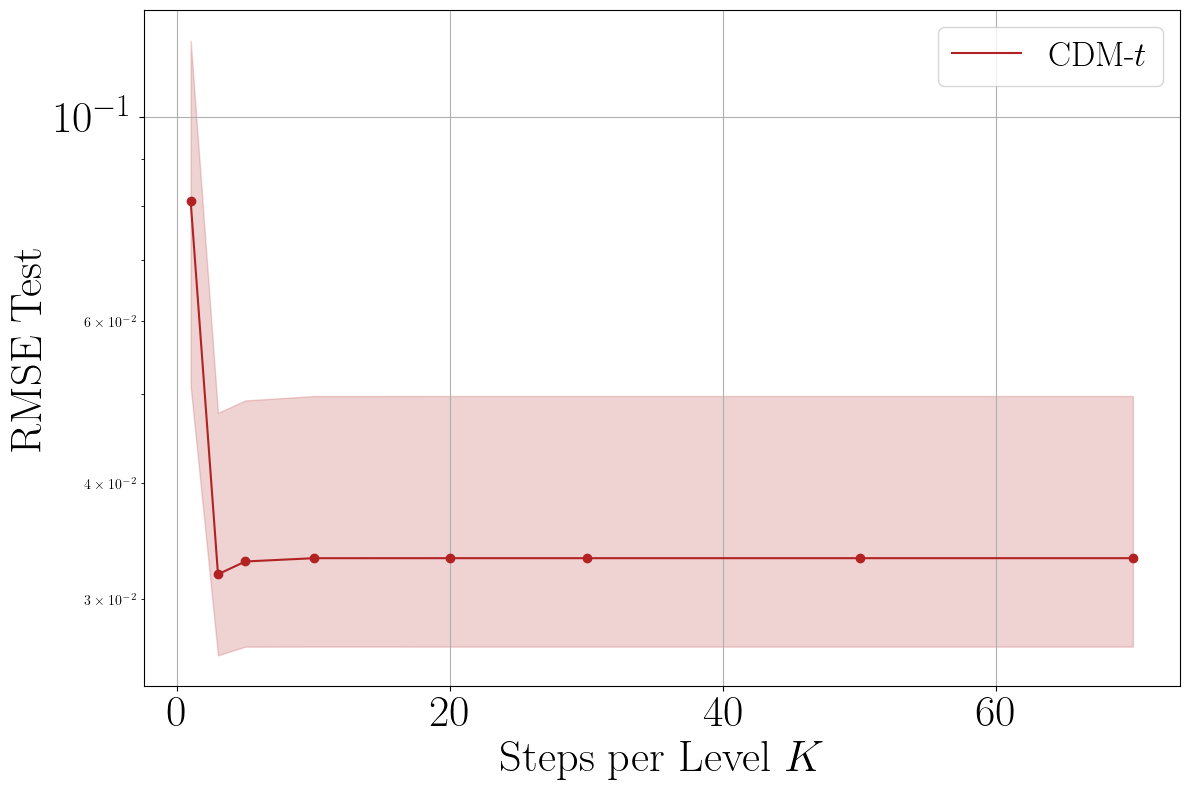

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

color = "firebrick"

plt.plot(K_size_vec, mean_refine_plot_K, color=color, label=r"CDM-$t$")
plt.plot(K_size_vec, mean_refine_plot_K, 'o', color=color)
plt.fill_between(K_size_vec,
                    np.abs(mean_refine_plot_K - std_refine_plot_K)+1e-2,
                    mean_refine_plot_K + std_refine_plot_K,
                    alpha=0.2, color=color)


plt.xlabel(r'Steps per Level $K$', fontsize=32)
plt.ylabel(r'RMSE Test', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
# plt.legend(fontsize=25)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.legend(fontsize=25)
# plt.ylim(0.025, 0.04)
plt.yscale('log')
plt.tight_layout()
plt.grid()

plt.savefig("scaling_inference_K_CDM-t_V3.png")

In [16]:
print(mean_refine_plot_K)

[0.08092953 0.03188036 0.0329166  0.03318771 0.03318956 0.03318956
 0.03318956 0.03318956]


In [17]:


def nb_level_ebm_pcdae_study(nb_levels_vec):

    test_init_vec = []
    test_refine_vec = []
    test_refine2_vec = []
    
    for counter, nb_levels in enumerate(nb_levels_vec):
        
        aux_init = []
        aux_refine = []
        aux_refine2 = []
        
        for idx in range(len(ebm_pcdae_vec)):
            
            torch.manual_seed(seed_vec[idx])
            np.random.seed(seed_vec[idx])
            
            test_dataset, test_dataloader = ebm_pcdae_vec[idx]['data']
            scaler_X, scaler_Y = ebm_pcdae_vec[idx]['scalers']
            ebm_pcdae = ebm_pcdae_vec[idx]['ebm_pcdae']
            s_noise, sigma_max = ebm_pcdae_vec[idx]['sigmas']
            noise_dist = ebm_pcdae_vec[idx]['noise_dist']
            
            test_init_loss = 0.0
            test_T_loss = 0
            test_Tadapt_loss = 0
    
            
            for i, (x, y) in enumerate(test_dataloader):
                
                y_init = torch.randn_like(y)
                y_T = inference.inference_blind_adaptive_ODE(ebm_pcdae, x, y_init, eta=0.1, max_steps=nb_levels, eps_conv=1e-5, eps_clip=None)
                y_Tadapt = inference.inference_blind_adaptive_ODE(ebm_pcdae, x, y_init, eta=1.0, max_steps=nb_levels, eps_conv=1e-5, eps_clip=None, adaptative=True)
        
                loss_init = nn.MSELoss()(y_init, y)
                loss_T = nn.MSELoss()(y_T, y)
                loss_Tadapt = nn.MSELoss()(y_Tadapt, y)
                
                test_init_loss += loss_init.item()
                test_T_loss += loss_T.item()
                test_Tadapt_loss += loss_Tadapt.item()
        
            test_init_loss /= len(test_dataloader)
            test_T_loss /= len(test_dataloader)
            test_Tadapt_loss /= len(test_dataloader)
            
            aux_init.append(test_init_loss)
            aux_refine.append(test_T_loss)
            aux_refine2.append(test_Tadapt_loss)
        
        test_init_vec.append(aux_init)
        test_refine_vec.append(aux_refine)
        test_refine2_vec.append(aux_refine2)
        
        print("counter: ", (counter+1)/len(nb_levels_vec))
        
    return test_init_vec, test_refine_vec, test_refine2_vec

In [18]:
# K_size_vec = [100, 400, 800, 1200, 2000, 3000, 4500, 6000, 8000, 10000]

K_size_vec = [1, 5, 10, 15, 20, 30, 50, 80, 100, 120, 140, 160, 180, 200]

test_init_ebm, test_refine_ebm, test_refine2_ebm = nb_level_ebm_pcdae_study(K_size_vec)


counter:  0.07142857142857142
counter:  0.14285714285714285
counter:  0.21428571428571427
counter:  0.2857142857142857
counter:  0.35714285714285715
counter:  0.42857142857142855
counter:  0.5
counter:  0.5714285714285714
counter:  0.6428571428571429
counter:  0.7142857142857143
counter:  0.7857142857142857
counter:  0.8571428571428571
steps:  179
steps:  175
steps:  161
steps:  178
counter:  0.9285714285714286
steps:  179
steps:  175
steps:  161
steps:  181
steps:  178
steps:  185
counter:  1.0


In [19]:
test_refine_ebm_arr = np.array(test_refine_ebm)
test_refine2_ebm_arr = np.array(test_refine2_ebm)
mean_refine_ebm = np.mean(np.sqrt(test_refine_ebm_arr), axis=1)
mean_refine2_ebm = np.mean(np.sqrt(test_refine2_ebm_arr), axis=1)
std_refine_ebm = np.std(np.sqrt(test_refine_ebm_arr), axis=1)
std_refine2_ebm = np.std(np.sqrt(test_refine2_ebm_arr), axis=1)


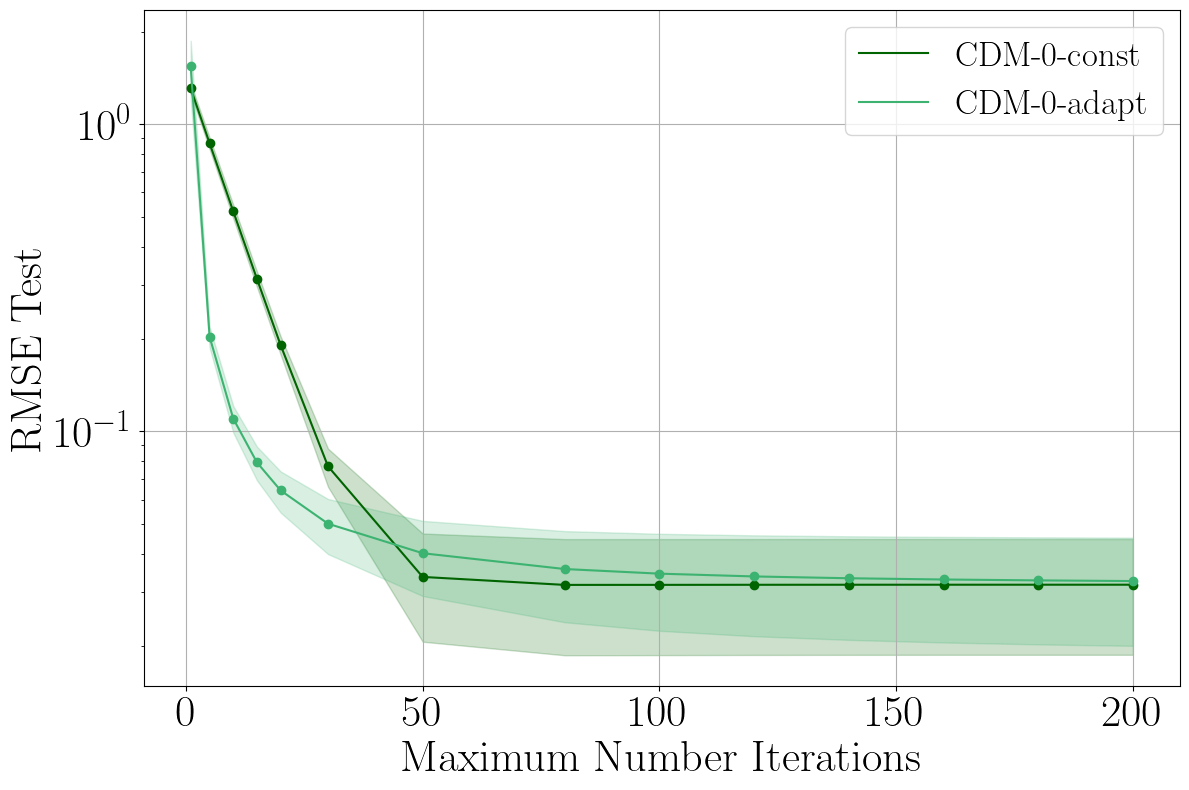

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

EBM1_color = "darkgreen"
EBM2_color = "mediumseagreen"

plt.plot(K_size_vec, mean_refine_ebm, color=EBM1_color, label=r"CDM-$0$-const")
plt.plot(K_size_vec, mean_refine_ebm, 'o', color=EBM1_color)
plt.fill_between(K_size_vec,
                    mean_refine_ebm - std_refine_ebm,
                    mean_refine_ebm + std_refine_ebm,
                    alpha=0.2, color=EBM1_color)


plt.plot(K_size_vec, mean_refine2_ebm, color=EBM2_color, label=r"CDM-$0$-adapt")
plt.plot(K_size_vec, mean_refine2_ebm, 'o', color=EBM2_color)
plt.fill_between(K_size_vec,
                    mean_refine2_ebm - std_refine2_ebm,
                    mean_refine2_ebm + std_refine2_ebm,
                    alpha=0.2, color=EBM2_color)


plt.xlabel(r'Maximum Number Iterations', fontsize=32)
plt.ylabel(r'RMSE Test', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
plt.legend(fontsize=25)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
# plt.legend(fontsize=25)
# plt.ylim(0.025, 0.04)
plt.yscale('log')
plt.tight_layout()
plt.grid()

plt.savefig("scaling_inference_CDM-0_V3.png")

In [21]:
print(mean_refine_ebm)
print(mean_refine2_ebm)

[1.30980978 0.86746128 0.52029252 0.31362934 0.19090573 0.07696438
 0.03357664 0.03162652 0.03163522 0.03165422 0.03166467 0.03166958
 0.03167178 0.03167276]
[1.54438214 0.20309153 0.10997944 0.07921452 0.06422584 0.05004984
 0.04010687 0.03562438 0.0344098  0.03369847 0.03324426 0.03293541
 0.0327151  0.03255195]


In [22]:

# [1.11571503 0.51067191 0.26190507 0.17756552 0.10833321 0.06622353
#  0.03374927 0.03007173 0.03007173 0.03007173] #### 0.01

# [0.41314883 0.10833442 0.04195739 0.03007142 0.03007142 0.03007142
#  0.03007142 0.03007142 0.03007142 0.03007142] ### 0.05 ebm